<a href="https://colab.research.google.com/github/ctrivino1/Spy-Plane-Project/blob/main/Spy_planes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spy plane data

Import the data set

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
planes = pd.read_csv("planes_features.csv")

train_dat = pd.read_csv("train(1).csv")

faa_reg = pd.read_csv("faa_registration.csv", error_bad_lines=False)

feds = pd.read_csv("feds.csv")

new_dat = pd.read_csv("new_plane_data.csv")
# new_plane_data was created in Rstudio using:
"""
planes <- read_csv("C:/Users/Admin/Downloads/planes_features.csv") 

# convert type to integers, as new variable type2, so it can be used by the random forest algorithm
planes <- planes %>%
  mutate(type2=as.integer(as.factor(type)))

# load training data and join to the planes_features data
train <- read_csv("C:/Users/Admin/Downloads/train(1).csv") %>%
  inner_join(planes, by="adshex")

feds <- read_csv("C:/Users/Admin/Downloads/feds.csv")

# create dataset to classify
classify <- anti_join(planes, train) %>%
  anti_join(feds)

view(classify)


write_csv(classify, "new_plane_data.csv", na="")

"""

new_dat.head()

,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,type2
0,A,0.120253,0.075949,0.183544,0.335443,0.284810,0.088608,0.044304,0.069620,0.120253,0.677215,0.021824,0.020550,0.062330,0.100713,0.794582,0.042374,0.060971,0.066831,0.106403,0.723421,0.020211,0.048913,0.270550,0.344090,0.097317,0.186651,0.011379,0.009426,158,0,11776,GRND,249
1,A00000,0.211735,0.155612,0.181122,0.198980,0.252551,0.204082,0.183673,0.168367,0.173469,0.267857,0.107348,0.143410,0.208139,0.177013,0.364090,0.177318,0.114457,0.129648,0.197694,0.380882,0.034976,0.048127,0.240732,0.356314,0.116116,0.159325,0.012828,0.013628,392,0,52465,TBM7,432
2,A00008,0.125000,0.041667,0.208333,0.166667,0.458333,0.125000,0.083333,0.125000,0.166667,0.500000,0.187960,0.278952,0.221048,0.190257,0.121783,0.014706,0.053309,0.149816,0.279871,0.502298,0.029871,0.044118,0.202665,0.380515,0.094669,0.182904,0.014706,0.020221,24,0,2176,PA46,351
3,A0001E,0.100000,0.200000,0.200000,0.400000,0.100000,0.100000,0.000000,0.100000,0.400000,0.400000,0.007937,0.026984,0.084127,0.179365,0.701587,0.041270,0.085714,0.039683,0.111111,0.722222,0.019048,0.049206,0.249206,0.326984,0.112698,0.206349,0.012698,0.011111,10,1135,630,C56X,127
4,A0002B,0.166667,0.166667,0.000000,0.666667,0.000000,0.333333,0.000000,0.000000,0.666667,0.000000,0.767405,0.191456,0.023734,0.017405,0.000000,0.150316,0.113924,0.178797,0.534810,0.022152,0.001582,0.009494,0.281646,0.416139,0.112342,0.169304,0.001582,0.001582,6,2356,632,C82S,134


Making the training data

In [ ]:
dat = pd.merge(planes,train_dat,on='adshex')
dat.head()

,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,class
0,A00002,0.517241,0.103448,0.103448,0.103448,0.172414,0.862069,0.137931,0.000000,0.000000,0.000000,0.990792,0.000921,0.000000,0.000000,0.008287,0.599448,0.400552,0.000000,0.000000,0.000000,0.105893,0.090239,0.174954,0.244015,0.034070,0.202578,0.021179,0.068140,29,0,1086,SHIP,other
1,A00220,0.000000,0.254902,0.176471,0.313725,0.254902,0.058824,0.372549,0.294118,0.215686,0.058824,0.052650,0.191676,0.419769,0.329805,0.006099,0.244327,0.235985,0.123329,0.307023,0.089335,0.034801,0.038389,0.263342,0.375998,0.132030,0.120011,0.008611,0.006906,51,0,11149,RV10,other
2,A0041E,0.142857,0.285714,0.000000,0.571429,0.000000,0.285714,0.142857,0.285714,0.285714,0.000000,0.009050,0.135747,0.426848,0.322775,0.105581,0.179487,0.067873,0.352941,0.399698,0.000000,0.010558,0.009050,0.108597,0.657617,0.090498,0.078431,0.010558,0.019608,7,0,663,SR22,other
3,A00889,0.000000,0.120000,0.200000,0.080000,0.600000,0.000000,0.200000,0.120000,0.280000,0.400000,0.005785,0.059895,0.187936,0.628297,0.118087,0.058448,0.122426,0.068402,0.582865,0.167858,0.002978,0.009784,0.078782,0.814361,0.065339,0.023907,0.001276,0.001702,25,7760,11754,SR22,other
4,A008BE,0.000000,0.300000,0.200000,0.200000,0.300000,0.000000,0.300000,0.200000,0.300000,0.200000,0.183099,0.380282,0.152113,0.218310,0.066197,0.108451,0.029577,0.314085,0.102817,0.445070,0.021127,0.018310,0.250704,0.436620,0.092958,0.145070,0.001408,0.009859,10,1200,710,PA24,other


In [ ]:
dat["class"].value_counts()

other      500
surveil     97
Name: class, dtype: int64

In [ ]:
dat.head()

,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,class
0,A00002,0.517241,0.103448,0.103448,0.103448,0.172414,0.862069,0.137931,0.000000,0.000000,0.000000,0.990792,0.000921,0.000000,0.000000,0.008287,0.599448,0.400552,0.000000,0.000000,0.000000,0.105893,0.090239,0.174954,0.244015,0.034070,0.202578,0.021179,0.068140,29,0,1086,SHIP,other
1,A00220,0.000000,0.254902,0.176471,0.313725,0.254902,0.058824,0.372549,0.294118,0.215686,0.058824,0.052650,0.191676,0.419769,0.329805,0.006099,0.244327,0.235985,0.123329,0.307023,0.089335,0.034801,0.038389,0.263342,0.375998,0.132030,0.120011,0.008611,0.006906,51,0,11149,RV10,other
2,A0041E,0.142857,0.285714,0.000000,0.571429,0.000000,0.285714,0.142857,0.285714,0.285714,0.000000,0.009050,0.135747,0.426848,0.322775,0.105581,0.179487,0.067873,0.352941,0.399698,0.000000,0.010558,0.009050,0.108597,0.657617,0.090498,0.078431,0.010558,0.019608,7,0,663,SR22,other
3,A00889,0.000000,0.120000,0.200000,0.080000,0.600000,0.000000,0.200000,0.120000,0.280000,0.400000,0.005785,0.059895,0.187936,0.628297,0.118087,0.058448,0.122426,0.068402,0.582865,0.167858,0.002978,0.009784,0.078782,0.814361,0.065339,0.023907,0.001276,0.001702,25,7760,11754,SR22,other
4,A008BE,0.000000,0.300000,0.200000,0.200000,0.300000,0.000000,0.300000,0.200000,0.300000,0.200000,0.183099,0.380282,0.152113,0.218310,0.066197,0.108451,0.029577,0.314085,0.102817,0.445070,0.021127,0.018310,0.250704,0.436620,0.092958,0.145070,0.001408,0.009859,10,1200,710,PA24,other


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

dat["y"] = dat["class"]
ord_enc = OrdinalEncoder()
dat["type2"] = ord_enc.fit_transform(dat[["type"]])

dat.head()

,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,class,y,type2
0,A00002,0.517241,0.103448,0.103448,0.103448,0.172414,0.862069,0.137931,0.000000,0.000000,0.000000,0.990792,0.000921,0.000000,0.000000,0.008287,0.599448,0.400552,0.000000,0.000000,0.000000,0.105893,0.090239,0.174954,0.244015,0.034070,0.202578,0.021179,0.068140,29,0,1086,SHIP,other,other,119.0
1,A00220,0.000000,0.254902,0.176471,0.313725,0.254902,0.058824,0.372549,0.294118,0.215686,0.058824,0.052650,0.191676,0.419769,0.329805,0.006099,0.244327,0.235985,0.123329,0.307023,0.089335,0.034801,0.038389,0.263342,0.375998,0.132030,0.120011,0.008611,0.006906,51,0,11149,RV10,other,other,108.0
2,A0041E,0.142857,0.285714,0.000000,0.571429,0.000000,0.285714,0.142857,0.285714,0.285714,0.000000,0.009050,0.135747,0.426848,0.322775,0.105581,0.179487,0.067873,0.352941,0.399698,0.000000,0.010558,0.009050,0.108597,0.657617,0.090498,0.078431,0.010558,0.019608,7,0,663,SR22,other,other,121.0
3,A00889,0.000000,0.120000,0.200000,0.080000,0.600000,0.000000,0.200000,0.120000,0.280000,0.400000,0.005785,0.059895,0.187936,0.628297,0.118087,0.058448,0.122426,0.068402,0.582865,0.167858,0.002978,0.009784,0.078782,0.814361,0.065339,0.023907,0.001276,0.001702,25,7760,11754,SR22,other,other,121.0
4,A008BE,0.000000,0.300000,0.200000,0.200000,0.300000,0.000000,0.300000,0.200000,0.300000,0.200000,0.183099,0.380282,0.152113,0.218310,0.066197,0.108451,0.029577,0.314085,0.102817,0.445070,0.021127,0.018310,0.250704,0.436620,0.092958,0.145070,0.001408,0.009859,10,1200,710,PA24,other,other,97.0


# Feature importance chart:
"Poor man's heatmap" (trademarked)

In [ ]:
dat1 = dat

dat1["y"] = pd.get_dummies(dat1["y"])

dat1.head()



,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,class,y,type2
0,A00002,0.517241,0.103448,0.103448,0.103448,0.172414,0.862069,0.137931,0.000000,0.000000,0.000000,0.990792,0.000921,0.000000,0.000000,0.008287,0.599448,0.400552,0.000000,0.000000,0.000000,0.105893,0.090239,0.174954,0.244015,0.034070,0.202578,0.021179,0.068140,29,0,1086,SHIP,other,1,119.0
1,A00220,0.000000,0.254902,0.176471,0.313725,0.254902,0.058824,0.372549,0.294118,0.215686,0.058824,0.052650,0.191676,0.419769,0.329805,0.006099,0.244327,0.235985,0.123329,0.307023,0.089335,0.034801,0.038389,0.263342,0.375998,0.132030,0.120011,0.008611,0.006906,51,0,11149,RV10,other,1,108.0
2,A0041E,0.142857,0.285714,0.000000,0.571429,0.000000,0.285714,0.142857,0.285714,0.285714,0.000000,0.009050,0.135747,0.426848,0.322775,0.105581,0.179487,0.067873,0.352941,0.399698,0.000000,0.010558,0.009050,0.108597,0.657617,0.090498,0.078431,0.010558,0.019608,7,0,663,SR22,other,1,121.0
3,A00889,0.000000,0.120000,0.200000,0.080000,0.600000,0.000000,0.200000,0.120000,0.280000,0.400000,0.005785,0.059895,0.187936,0.628297,0.118087,0.058448,0.122426,0.068402,0.582865,0.167858,0.002978,0.009784,0.078782,0.814361,0.065339,0.023907,0.001276,0.001702,25,7760,11754,SR22,other,1,121.0
4,A008BE,0.000000,0.300000,0.200000,0.200000,0.300000,0.000000,0.300000,0.200000,0.300000,0.200000,0.183099,0.380282,0.152113,0.218310,0.066197,0.108451,0.029577,0.314085,0.102817,0.445070,0.021127,0.018310,0.250704,0.436620,0.092958,0.145070,0.001408,0.009859,10,1200,710,PA24,other,1,97.0


In [ ]:
dat1.y.value_counts()

1    500
0     97
Name: y, dtype: int64

In [ ]:
corY = pd.DataFrame(dat1.corr().y).reset_index()



alt.Chart(corY).mark_bar().encode(
    alt.X("index",sort="y"),
    alt.Y("y")
).properties(
      title = {
        "text":  "Bar chart coorelation plot of data features",
        "subtitle": "This shows that as the target feature goes to value 1. Which signifies the plane class 'other' "
        }).configure_title(
      fontSize = 15, 
      anchor = "start", 
      subtitleFontSize = 11)

alt.Chart(...)

In [ ]:
dat.head()

,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,class,y,type2
0,A00002,0.517241,0.103448,0.103448,0.103448,0.172414,0.862069,0.137931,0.000000,0.000000,0.000000,0.990792,0.000921,0.000000,0.000000,0.008287,0.599448,0.400552,0.000000,0.000000,0.000000,0.105893,0.090239,0.174954,0.244015,0.034070,0.202578,0.021179,0.068140,29,0,1086,SHIP,other,1,119.0
1,A00220,0.000000,0.254902,0.176471,0.313725,0.254902,0.058824,0.372549,0.294118,0.215686,0.058824,0.052650,0.191676,0.419769,0.329805,0.006099,0.244327,0.235985,0.123329,0.307023,0.089335,0.034801,0.038389,0.263342,0.375998,0.132030,0.120011,0.008611,0.006906,51,0,11149,RV10,other,1,108.0
2,A0041E,0.142857,0.285714,0.000000,0.571429,0.000000,0.285714,0.142857,0.285714,0.285714,0.000000,0.009050,0.135747,0.426848,0.322775,0.105581,0.179487,0.067873,0.352941,0.399698,0.000000,0.010558,0.009050,0.108597,0.657617,0.090498,0.078431,0.010558,0.019608,7,0,663,SR22,other,1,121.0
3,A00889,0.000000,0.120000,0.200000,0.080000,0.600000,0.000000,0.200000,0.120000,0.280000,0.400000,0.005785,0.059895,0.187936,0.628297,0.118087,0.058448,0.122426,0.068402,0.582865,0.167858,0.002978,0.009784,0.078782,0.814361,0.065339,0.023907,0.001276,0.001702,25,7760,11754,SR22,other,1,121.0
4,A008BE,0.000000,0.300000,0.200000,0.200000,0.300000,0.000000,0.300000,0.200000,0.300000,0.200000,0.183099,0.380282,0.152113,0.218310,0.066197,0.108451,0.029577,0.314085,0.102817,0.445070,0.021127,0.018310,0.250704,0.436620,0.092958,0.145070,0.001408,0.009859,10,1200,710,PA24,other,1,97.0


Feature scaling 


In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')


y = dat["y"]
f = dat.drop(["y","class","adshex","type"],axis=1)
features = pd.get_dummies(f)

sc = StandardScaler()

sc.fit(features)


X = pd.DataFrame(sc.transform(features))

ro = RandomOverSampler()

X_new, y_new = ro.fit_resample(X, y)

y_2 = pd.DataFrame(y_new)
X_2= pd.DataFrame(X_new)

y_2.value_counts()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1    500
0    500
dtype: int64

In [ ]:
print(X)
len(pd.DataFrame(X).columns)

           0         1         2   ...        29        30        31
0    2.272380 -0.534690 -0.622209  ... -0.794615 -0.412111  1.027256
1   -1.102153  0.628151 -0.078249  ... -0.794615  0.114334  0.777590
2   -0.170139  0.864724 -1.392817  ... -0.794615 -0.434240  1.072650
3   -1.102153 -0.407608  0.097026  ...  3.016836  0.145984  1.072650
4   -1.102153  0.974408  0.097026  ... -0.205215 -0.431781  0.527923
..        ...       ...       ...  ...       ...       ...       ...
592 -1.102153  0.551341 -0.784718  ... -0.205215  0.044232 -1.378622
593 -0.040091 -0.971842  0.166321  ... -0.794615 -0.425870 -1.265137
594 -0.422560 -0.049308  0.779871  ... -0.136452 -0.214413  0.664105
595  1.171396 -0.398302 -0.377015  ... -0.794615 -0.252237 -1.083561
596 -1.102153  1.341610 -0.259241  ... -0.205215  0.156814  1.140741

[597 rows x 32 columns]


32

Random forest classifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size = 0.2, random_state = 1)



rfc = RandomForestClassifier(n_estimators = 2000, random_state = 0)
rfc.fit(X_train, y_train)

rfc.score(X_test, y_test) # looks like there might be overfitting

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.99

# Model Validation

k-fold cross validation

In [ ]:

from sklearn.model_selection import cross_val_score

# is supposed to be used on the training set
accuracies = cross_val_score(estimator = rfc, X = X_train, y = y_train, cv = 10) # 4 essitional paramters
#1. estimator(which is my classifier)
#2. input features of the training set X_train
#3.input the dependent variable of the trianing set y_train
#4. number of folds I want to have
# classifier comes from the model class I choose

print("Accuracy: {:.2f} %".format(accuracies.mean()*100)) # a float with two decimals after the comma, * 100 makes it a percentage
# accuracies.mean() gives me the average accuracies for the 10 tests
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100)) # shows standard deviation


'\n# is supposed to be used on the training set\naccuracies = cross_val_score(estimator = rfc, X = X_train, y = y_train, cv = 10) # 4 essitional paramters\n#1. estimator(which is my classifier)\n#2. input features of the training set X_train\n#3.input the dependent variable of the trianing set y_train\n#4. number of folds I want to have\n# classifier comes from the model class I choose\n\nprint("Accuracy: {:.2f} %".format(accuracies.mean()*100)) # a float with two decimals after the comma, * 100 makes it a percentage\n# accuracies.mean() gives me the average accuracies for the 10 tests\nprint("Standard Deviation: {:.2f} %".format(accuracies.std()*100)) # shows standard deviation\n'

Confusion matrix

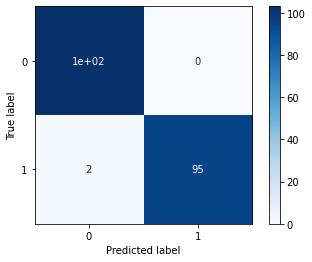

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(rfc, X_test, y_test, cmap = "Blues")



Interpreation of confusion matrix

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix

y_pred = rfc.predict(X_test)

y_pred_pos = rfc.predict(X_test)

y_pred_neg = rfc.predict(X_test)

## Displaying the data

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[103   0]
 [  2  95]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       103
           1       1.00      0.98      0.99        97

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



# Predicting on new data

In [ ]:
new_dat.head()
len(new_dat)

19160

In [ ]:
new_dat1 = new_dat.drop(["adshex","type"],axis=1)
len(new_dat1.columns)

32

In [ ]:
pred = pd.DataFrame(rfc.predict(sc.transform(new_dat1)))

In [ ]:
pred.head()

,0
0,1
1,1
2,1
3,1
4,1


In [ ]:
new_dat.insert(34, "predictions", pred.values, True)

In [ ]:
final_dat = new_dat.drop(["type2"],axis=1)

In [ ]:
final_dat.predictions.value_counts()

1    19054
0      106
Name: predictions, dtype: int64

In [ ]:
final_dat["predicted_type"] = final_dat.predictions.replace(to_replace=[1, 0], value=["other", "surveil"])

In [ ]:
final_dat.head()

,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,predictions,predicted_type
0,A,0.120253,0.075949,0.183544,0.335443,0.284810,0.088608,0.044304,0.069620,0.120253,0.677215,0.021824,0.020550,0.062330,0.100713,0.794582,0.042374,0.060971,0.066831,0.106403,0.723421,0.020211,0.048913,0.270550,0.344090,0.097317,0.186651,0.011379,0.009426,158,0,11776,GRND,1,other
1,A00000,0.211735,0.155612,0.181122,0.198980,0.252551,0.204082,0.183673,0.168367,0.173469,0.267857,0.107348,0.143410,0.208139,0.177013,0.364090,0.177318,0.114457,0.129648,0.197694,0.380882,0.034976,0.048127,0.240732,0.356314,0.116116,0.159325,0.012828,0.013628,392,0,52465,TBM7,1,other
2,A00008,0.125000,0.041667,0.208333,0.166667,0.458333,0.125000,0.083333,0.125000,0.166667,0.500000,0.187960,0.278952,0.221048,0.190257,0.121783,0.014706,0.053309,0.149816,0.279871,0.502298,0.029871,0.044118,0.202665,0.380515,0.094669,0.182904,0.014706,0.020221,24,0,2176,PA46,1,other
3,A0001E,0.100000,0.200000,0.200000,0.400000,0.100000,0.100000,0.000000,0.100000,0.400000,0.400000,0.007937,0.026984,0.084127,0.179365,0.701587,0.041270,0.085714,0.039683,0.111111,0.722222,0.019048,0.049206,0.249206,0.326984,0.112698,0.206349,0.012698,0.011111,10,1135,630,C56X,1,other
4,A0002B,0.166667,0.166667,0.000000,0.666667,0.000000,0.333333,0.000000,0.000000,0.666667,0.000000,0.767405,0.191456,0.023734,0.017405,0.000000,0.150316,0.113924,0.178797,0.534810,0.022152,0.001582,0.009494,0.281646,0.416139,0.112342,0.169304,0.001582,0.001582,6,2356,632,C82S,1,other


In [ ]:
final_dat.predicted_type.value_counts()

other      19054
surveil      106
Name: predicted_type, dtype: int64

In [ ]:
final_dat.predicted_type.value_counts(normalize=True)

other      0.994468
surveil    0.005532
Name: predicted_type, dtype: float64

The probability of each prediction being a "surveil" plane or "other"

In [ ]:
prob = pd.DataFrame(rfc.predict_proba(sc.transform(new_dat1)))

In [ ]:
prob.head()

,0,1
0,0.0025,0.9975
1,0.0415,0.9585
2,0.0035,0.9965
3,0.0040,0.9960
4,0.0755,0.9245


In [ ]:
final_dat.insert(35, "proabibility_of_spy_plane", prob[0].values, True)
final_dat.insert(36, "proabibility_of_other_plane", prob[1].values, True)


In [ ]:
final_dat.head()

,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,predictions,predicted_type,proabibility_of_spy_plane,proabibility_of_other_plane
0,A,0.120253,0.075949,0.183544,0.335443,0.284810,0.088608,0.044304,0.069620,0.120253,0.677215,0.021824,0.020550,0.062330,0.100713,0.794582,0.042374,0.060971,0.066831,0.106403,0.723421,0.020211,0.048913,0.270550,0.344090,0.097317,0.186651,0.011379,0.009426,158,0,11776,GRND,1,other,0.0025,0.9975
1,A00000,0.211735,0.155612,0.181122,0.198980,0.252551,0.204082,0.183673,0.168367,0.173469,0.267857,0.107348,0.143410,0.208139,0.177013,0.364090,0.177318,0.114457,0.129648,0.197694,0.380882,0.034976,0.048127,0.240732,0.356314,0.116116,0.159325,0.012828,0.013628,392,0,52465,TBM7,1,other,0.0415,0.9585
2,A00008,0.125000,0.041667,0.208333,0.166667,0.458333,0.125000,0.083333,0.125000,0.166667,0.500000,0.187960,0.278952,0.221048,0.190257,0.121783,0.014706,0.053309,0.149816,0.279871,0.502298,0.029871,0.044118,0.202665,0.380515,0.094669,0.182904,0.014706,0.020221,24,0,2176,PA46,1,other,0.0035,0.9965
3,A0001E,0.100000,0.200000,0.200000,0.400000,0.100000,0.100000,0.000000,0.100000,0.400000,0.400000,0.007937,0.026984,0.084127,0.179365,0.701587,0.041270,0.085714,0.039683,0.111111,0.722222,0.019048,0.049206,0.249206,0.326984,0.112698,0.206349,0.012698,0.011111,10,1135,630,C56X,1,other,0.0040,0.9960
4,A0002B,0.166667,0.166667,0.000000,0.666667,0.000000,0.333333,0.000000,0.000000,0.666667,0.000000,0.767405,0.191456,0.023734,0.017405,0.000000,0.150316,0.113924,0.178797,0.534810,0.022152,0.001582,0.009494,0.281646,0.416139,0.112342,0.169304,0.001582,0.001582,6,2356,632,C82S,1,other,0.0755,0.9245


In [ ]:
# selecting the top 100 candidates

spy_planes = final_dat.nlargest(100, ['proabibility_of_spy_plane'])
spy_planes.head()

,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,predictions,predicted_type,proabibility_of_spy_plane,proabibility_of_other_plane
7850,A4FB3C,0.416667,0.125000,0.083333,0.041667,0.333333,0.458333,0.458333,0.083333,0.000000,0.000000,0.562937,0.226224,0.138811,0.056294,0.015734,0.000000,0.009091,0.039860,0.866434,0.084615,0.144406,0.226923,0.222378,0.268182,0.013986,0.062587,0.004196,0.017483,24,5310,2860,P210,0,surveil,0.9750,0.0250
7129,A497C0,0.226415,0.169811,0.150943,0.150943,0.301887,0.264151,0.320755,0.320755,0.056604,0.037736,0.344421,0.422552,0.191865,0.035408,0.005755,0.044382,0.110710,0.372805,0.369099,0.103004,0.243075,0.204643,0.233223,0.117245,0.040675,0.081350,0.008291,0.010632,53,5367,10252,PA32,0,surveil,0.9680,0.0320
2121,A13098,0.166667,0.166667,0.166667,0.083333,0.416667,0.250000,0.583333,0.166667,0.000000,0.000000,0.866572,0.071664,0.035361,0.020745,0.005658,0.053748,0.123055,0.665724,0.157473,0.000000,0.151344,0.176803,0.181047,0.300802,0.019331,0.085809,0.010372,0.028289,12,4415,2121,unknown,0,surveil,0.9475,0.0525
83,A005D8,0.241379,0.137931,0.137931,0.103448,0.379310,0.241379,0.068966,0.310345,0.206897,0.172414,0.245460,0.389500,0.232983,0.048178,0.083879,0.000988,0.005559,0.018653,0.096603,0.878196,0.105991,0.220630,0.335145,0.193823,0.015442,0.070043,0.007288,0.016553,29,5011,8095,unknown,0,surveil,0.9285,0.0715
2229,A144AF,0.328358,0.134328,0.074627,0.029851,0.432836,0.492537,0.328358,0.164179,0.000000,0.014925,0.134059,0.274446,0.197484,0.148554,0.245457,0.001251,0.005371,0.008167,0.053271,0.931940,0.152969,0.248841,0.266132,0.175116,0.010448,0.064013,0.014495,0.018247,67,5103,13591,unknown,0,surveil,0.9270,0.0730


In [ ]:
faa_reg.head()

,N-NUMBER,SERIAL NUMBER,MFR MDL CODE,ENG MFR MDL,YEAR MFR,TYPE REGISTRANT,NAME,STREET,STREET2,CITY,STATE,ZIP CODE,REGION,COUNTY,COUNTRY,LAST ACTION DATE,CERT ISSUE DATE,CERTIFICATION,TYPE AIRCRAFT,TYPE ENGINE,STATUS CODE,MODE S CODE,FRACT OWNER,AIR WORTH DATE,OTHER NAMES(1),OTHER NAMES(2),OTHER NAMES(3),OTHER NAMES(4),OTHER NAMES(5),EXPIRATION DATE,UNIQUE ID,KIT MFR,KIT MODEL,MODE S CODE HEX,X35
0,1,1071,3980115,54556.0,1988.0,5.0,FEDERAL AVIATION ADMINISTRATION,WASHINGTON REAGAN NATIONAL ARPT,3201 THOMAS AVE HANGAR 6,WASHINGTON,DC,20001,1,1.0,US,20160614,19900214.0,1T,5,5,V,50000001,NaN,19880909.0,NaN,NaN,NaN,NaN,NaN,20191130.0,524101,NaN,NaN,A00001,NaN
1,100,5334,7100510,17003.0,1940.0,1.0,BENE MARY D,PO BOX 329,NaN,KETCHUM,OK,743490329,2,97.0,US,20161218,20050506.0,1,4,1,V,50002263,NaN,19540430.0,NaN,NaN,NaN,NaN,NaN,20200430.0,600060,NaN,NaN,A004B3,NaN
2,10001,A28,9601202,67007.0,1928.0,1.0,PERRY AARON O,PO BOX 736,NaN,MULBERRY,FL,338600736,7,105.0,US,20160512,20130625.0,1,4,1,V,50003446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20190630.0,432072,NaN,NaN,A00726,NaN
3,10002,79-030,8930105,41525.0,1979.0,4.0,ENGLISH MARK,655 DOESKIN TRL,NaN,SANTA MARIA,CA,934556020,4,83.0,US,20140811,19960808.0,31,6,1,V,50003447,NaN,19960124.0,ENGLISH TRACY,NaN,NaN,NaN,NaN,20180131.0,831480,NaN,NaN,A00727,NaN
4,10003,1,056336T,NaN,NaN,1.0,CAMPBELL CHARLES N,604 CORDOVA CT,NaN,SALISBURY,NC,281466337,1,159.0,US,20150313,20150313.0,NaN,4,8,V,50003450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20180331.0,1173853,NaN,NaN,A00728,NaN


In [ ]:
faa_reg1 = faa_reg.iloc[:, [0,6,9,10,33]]

faa_reg1.columns.values[0] = "reg"
faa_reg1.columns.values[1] = "name"
faa_reg1.columns.values[4] = "adshex"


faa_reg1["reg"] = 'N' + faa_reg1['reg'].astype(str)

faa_reg1.head()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,reg,name,CITY,STATE,adshex
0,N1,FEDERAL AVIATION ADMINISTRATION,WASHINGTON,DC,A00001
1,N100,BENE MARY D,KETCHUM,OK,A004B3
2,N10001,PERRY AARON O,MULBERRY,FL,A00726
3,N10002,ENGLISH MARK,SANTA MARIA,CA,A00727
4,N10003,CAMPBELL CHARLES N,SALISBURY,NC,A00728



# Join to FAA registration data to obtain information on each plane's registration numbers and registered owners/operators

In [ ]:
candidates = faa_reg1.merge(spy_planes, on='adshex', how='left', indicator=False)
candidates.head()

,reg,name,CITY,STATE,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,predictions,predicted_type,proabibility_of_spy_plane,proabibility_of_other_plane
0,N1,FEDERAL AVIATION ADMINISTRATION,WASHINGTON,DC,A00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N100,BENE MARY D,KETCHUM,OK,A004B3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N10001,PERRY AARON O,MULBERRY,FL,A00726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N10002,ENGLISH MARK,SANTA MARIA,CA,A00727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N10003,CAMPBELL CHARLES N,SALISBURY,NC,A00728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Top 100 candidates

In [ ]:
pd.set_option('display.max_rows', 100)


final_candidates = candidates.nlargest(100, ['proabibility_of_spy_plane'])
final_candidates = final_candidates.iloc[:, [0,1,2,3,4,35,38,39,40]]


#final_candidates.head(100)

(print(final_candidates.drop(["reg","adshex","observations"],axis=1).head(100).to_markdown()))

len(final_candidates)

|        | name                                          | CITY               | STATE   | predicted_type   |   proabibility_of_spy_plane |   proabibility_of_other_plane |
|-------:|:----------------------------------------------|:-------------------|:--------|:-----------------|----------------------------:|------------------------------:|
| 126686 | CITY OF MESA ARIZONA                          | MESA               | AZ      | surveil          |                      0.975  |                        0.025  |
| 112682 | SCIFLY LLC                                    | SAN DIEGO          | CA      | surveil          |                      0.968  |                        0.032  |
| 149442 | CHAPARRAL AIR GROUP                           | GRAPEVINE          | TX      | surveil          |                      0.9265 |                        0.0735 |
| 183878 | ORANGE COUNTY SHERIFFS DEPARTMENT RNSP        | SANTA ANA          | CA      | surveil          |                      0.9145 |       

77

In [ ]:
final_candidates.proabibility_of_spy_plane.value_counts()

0.5295    2
0.6230    2
0.6085    2
0.5445    1
0.7410    1
0.5400    1
0.7590    1
0.8925    1
0.5165    1
0.6150    1
0.9265    1
0.6060    1
0.5230    1
0.9750    1
0.5875    1
0.8500    1
0.6570    1
0.6110    1
0.8940    1
0.5870    1
0.5225    1
0.6725    1
0.5670    1
0.5625    1
0.5550    1
0.6325    1
0.9015    1
0.6635    1
0.5740    1
0.7775    1
0.9680    1
0.5720    1
0.8350    1
0.5535    1
0.8980    1
0.9145    1
0.6490    1
0.6495    1
0.5140    1
0.5375    1
0.6880    1
0.5620    1
0.8320    1
0.5480    1
0.6330    1
0.6935    1
0.7630    1
0.5135    1
0.6660    1
0.5580    1
0.6940    1
0.7295    1
0.5475    1
0.5905    1
0.6735    1
0.6255    1
0.5455    1
0.5630    1
0.7870    1
0.7260    1
0.5910    1
0.6315    1
0.5180    1
0.8210    1
0.5975    1
0.7325    1
0.5160    1
0.5880    1
0.5390    1
0.7545    1
0.5985    1
0.7550    1
0.5750    1
0.6250    1
Name: proabibility_of_spy_plane, dtype: int64

# Data insights of final_candidates

In [70]:
# States with the highest probability of having a serveilence spy plane
alt.Chart(final_candidates).mark_bar().encode(
    alt.X("STATE", title="State", sort='y'),
    alt.Y("count(STATE)",title="Occurrences"),
    color="STATE").properties(
      title = {
        "text":  "States with the most 'Surveil' plane counts",
        "subtitle": "Based on the top 100 candidates candidates with the highest probability of being a 'Surveil' plane"
        }).configure_title(
      fontSize = 15, 
      anchor = "start", 
      subtitleFontSize = 11).properties(width=500,height=350)


alt.Chart(...)

In [ ]:
cities = final_candidates
cities["city_state"] = cities.CITY + " " + cities.STATE
cities.head()

,reg,name,CITY,STATE,adshex,observations,predicted_type,proabibility_of_spy_plane,proabibility_of_other_plane,city_state
126686,N42WB,CITY OF MESA ARIZONA,MESA,AZ,A4FB3C,2860.0,surveil,0.9750,0.0250,MESA AZ
112682,N3950M,SCIFLY LLC,SAN DIEGO,CA,A497C0,10252.0,surveil,0.9680,0.0320,SAN DIEGO CA
149442,N501GW,CHAPARRAL AIR GROUP,GRAPEVINE,TX,A63E52,8225.0,surveil,0.9265,0.0735,GRAPEVINE TX
183878,N6045C,ORANGE COUNTY SHERIFFS DEPARTMENT RNSP,SANTA ANA,CA,A7D925,45079.0,surveil,0.9145,0.0855,SANTA ANA CA
185795,N609TW,WRIGHT TIMOTHY C,NORTH CHESTERFIELD,VA,A7EA6C,3329.0,surveil,0.9015,0.0985,NORTH CHESTERFIELD VA


In [67]:
c5 = cities.groupby("city_state").filter(lambda x: len(x) >= 2)

alt.Chart(c5).mark_bar().encode(
    alt.Y("city_state:N", title="Location", sort="-x"),
    alt.X("count(city_state)",axis=alt.Axis(tickMinStep=1),title="Occurrences"), color="city_state",).properties(title = {
        "text":  "Top cities with significant 'Surveil' plane probability",
        "subtitle": "Based on the top 100 candidates candidates with the highest probability of being a 'Surveil' plane"
        }).configure_title(
      fontSize = 15, 
      anchor = "start", 
      subtitleFontSize = 11).properties(width=500,height=200)

alt.Chart(...)

In [71]:
business_name = pd.DataFrame(final_candidates.name.value_counts().nlargest(5).reset_index())
business_name.head()

# top businesses that were predicted to have spy planes

alt.Chart(business_name).mark_bar().encode(
    alt.Y("index:N", title="Company", sort="-x"),
    alt.X("name:Q",axis=alt.Axis(tickMinStep=1),title="Occurences"),color="index").properties(title = {
        "text":  "Top 5 recurring businesses",
        "subtitle": "Based on how many times the business is mentioned within the top 100"
        }).configure_title(
      fontSize = 15, 
      anchor = "start", 
      subtitleFontSize = 11).properties(width=500,height=200)

alt.Chart(...)

90th percentile candidate

In [ ]:
ninety_percent = final_candidates.query("proabibility_of_spy_plane >=.9")
print(ninety_percent.drop(["reg","adshex","CITY","STATE","observations"],axis=1).head(10).to_markdown())

|        | name                                   | predicted_type   |   proabibility_of_spy_plane |   proabibility_of_other_plane | city_state            |
|-------:|:---------------------------------------|:-----------------|----------------------------:|------------------------------:|:----------------------|
| 126686 | CITY OF MESA ARIZONA                   | surveil          |                      0.975  |                        0.025  | MESA AZ               |
| 112682 | SCIFLY LLC                             | surveil          |                      0.968  |                        0.032  | SAN DIEGO CA          |
| 149442 | CHAPARRAL AIR GROUP                    | surveil          |                      0.9265 |                        0.0735 | GRAPEVINE TX          |
| 183878 | ORANGE COUNTY SHERIFFS DEPARTMENT RNSP | surveil          |                      0.9145 |                        0.0855 | SANTA ANA CA          |
| 185795 | WRIGHT TIMOTHY C                       | survei

A few Honorable mentions from the top 100 candidates:

US AIR FORCE SPECIAL OPERATIONS COMMAND, SCIFLY LLC, AEROPTIC LLC.

In [ ]:
## dangerous code that messes things up

dat2 = dat
dat2 = dat2.replace(to_replace=['other', 'surveil'], value=[0, 1])

dat2["target"] = dat2["class"]

dat2 = dat2.drop(["y","class"],axis=1)

dat2.target.value_counts()

0    500
1     97
Name: target, dtype: int64

In [ ]:
corY1 = pd.DataFrame(dat2.corr().target).reset_index()



alt.Chart(corY1).mark_bar().encode(
    alt.X("index",sort="y"),
    alt.Y("target")
).properties(width=800,
      title = {
        "text":  "Bar chart coorelation plot of data features",
        "subtitle": "This shows that as the target feature goes to value 1. Which signifies the plane class 'surveil' "
        }).configure_title(
      fontSize = 15, 
      anchor = "start", 
      subtitleFontSize = 11)

alt.Chart(...)